In [1]:
import time
import torch
from utils import image_utils
from utils.image_utils import gen_index_file
from unet.dataset import SegThorImagesDataset
from torch.utils.data import DataLoader, random_split

from unet.simplified_unet_model import SimplifiedUNet
from unet.loss import GeneralizedDiceLoss, print_dice_by_category
from torch import optim
from torch import nn
import os 
import pandas as pd 
from torchvision.transforms import v2
from importlib import reload
import pandas as pd
from sklearn.model_selection import train_test_split 
import torch.nn.functional as F
from unet.loss import RectificationLoss
from torch.optim.lr_scheduler import ExponentialLR
from unet.Deeplab3 import load_deeplab

In [2]:
# if index file doesn't exist, generate and save 
filenames = image_utils.gen_index_file(root='./data/train')
filenames

Filename: data/train_patient_idx.csv already exists, skipping gen


In [3]:
DATA_DIR = '/home/jupyter/ecs271_dataset/data/train'
EXPERIMENT_DIR = '/home/jupyter/ecs271_dataset/models'
TRAIN_CSV = "data/train_patient_idx_sorted.csv"
VALID_CSV = "data/valid_patient_idx_sorted.csv"
INPUT_DATA_INDEX = 'data/train_patient_idx.csv'
TEST_CSV = "data/test_patient_idx.csv"

In [4]:
# split the source train data into 80/20 train/valid split if needed

df = pd.read_csv(INPUT_DATA_INDEX)
def split_to_train_valid_dfs(df, filenames = [TRAIN_CSV, VALID_CSV]):
    for file in filenames:
        if os.path.isfile(file):
            print(f"File exists: {file}, skipping")
            return

    print(f"One of files does not exist, splitting")

    train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

    # order by slice_idx for caching and speed up of DataLoader
    sorted_train = train_df.sort_index()
    sorted_valid = valid_df.sort_index()
    sorted_train.to_csv(TRAIN_CSV, index=False)
    sorted_valid.to_csv(VALID_CSV, index=False)
    
split_to_train_valid_dfs(df, [TRAIN_CSV, VALID_CSV])



File exists: data/train_patient_idx_sorted.csv, skipping


In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. ")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead.")

GPU is available. 


In [6]:

def create_experiment_dir(experiment_name, experiment_dir: str = EXPERIMENT_DIR):
    # Check if the directory exists and create it if it doesn't
    if experiment_name not in os.listdir(experiment_dir):
        os.makedirs(os.path.join(experiment_dir, experiment_name))
        print(f"Directory {experiment_name} created.")
    else:
        print(f"Directory {experiment_name} already exists.")    

In [7]:
experiment_name = "competing_ud_0607"

In [8]:
experiment_dir = EXPERIMENT_DIR
train_csv = TRAIN_CSV
valid_csv = VALID_CSV
data_dir = DATA_DIR
epochs = 10
lr = 1e-5
batch_size = 4
use_cache = True

create_experiment_dir(experiment_name, experiment_dir)
experiment_path = f"{experiment_dir}/{experiment_name}"

train_dataset = SegThorImagesDataset(
    patient_idx_file=train_csv,
    root_dir=data_dir,
    img_crop_size=312,
    mask_output_size=220,
    cache_size=1
)
valid_dataset = SegThorImagesDataset(
    patient_idx_file=valid_csv,
    root_dir=data_dir,
    img_crop_size=312,
    mask_output_size=220,
    cache_size=1
)

print(f"Length of Train: {len(train_dataset)}")
print(f"Length of Valid: {len(valid_dataset)}")
# test 
# indices = [0, 1, 2, 3]
# subset1 = [train_dataset[i] for i in indices]
# subset2 = [valid_dataset[i] for i in indices]
shuffle = not use_cache
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size, shuffle=shuffle)

model_1 = SimplifiedUNet(n_channels=1, n_classes=5, dropout=0.2)
model_2 = load_deeplab()
model_1.to(device), model_2.to(device)

optimizer_1 = optim.Adam(model_1.parameters(), lr=lr)
optimizer_2 = optim.Adam(model_2.parameters(), lr=lr)

scheduler1 = ExponentialLR(optimizer_1, gamma=0.9)
scheduler2 = ExponentialLR(optimizer_2, gamma=0.9)

generalized_dice = GeneralizedDiceLoss()
rl_loss = RectificationLoss()


Directory competing_ud_0607 already exists.
Length of Train: 4420
Length of Valid: 1105
ModifiedDeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
from tqdm import tqdm

# [ ] TODO: image transformations at dataloader similar to SegTHOR paper, also filtering out slices with no labels
# [ ] TODO: final evaluation of winning unet
# [ ] TODO: display the examples
epoch_train_losses_1, epoch_train_losses_2 = [], []
epoch_val_losses_1, epoch_val_losses_2 = [], []
for epoch in range(epochs):
    epoch_start_time = time.time()
    model_1.train()
    model_2.train()
    running_loss_1, running_loss_2 = 0.0, 0.0
    oar_dice_valid_1, oar_dice_valid_2 = [], []

    idx_time = epoch_start_time
    for idx, sample in tqdm(enumerate(train_dl)):
        start_time = time.time()
        inputs, targets = sample
        inputs = inputs.to(device)
        targets = targets.to(device)
        output_1, output_2 = model_1(inputs), model_2(inputs)
        output_1 = output_1.to(device)
        output_2 = output_2.to(device)

        output_1_proba, output_2_proba = F.softmax(F.sigmoid(output_1), dim=1), F.softmax(F.sigmoid(output_2), dim=1)
        # channels
        output_1_channels = rl_loss._probas_to_class_channels(output_1_proba)
        output_2_channels = rl_loss._probas_to_class_channels(output_2_proba)
        target_channels = rl_loss._targets_to_class_channels(targets).to(device)
        # disagreement mask
        disagreement_mask = ((output_1_channels == 1) ^ (output_2_channels == 1)).to(torch.int32)
        mse_1 = ((output_1_channels - target_channels) ** 2)
        mse_2 = ((output_2_channels - target_channels) ** 2)

        # mean by channel
        masked_mse_1 = (disagreement_mask * mse_1).mean(dim=(-1, -2))
        masked_mse_2 = (disagreement_mask * mse_2).mean(dim=(-1, -2))

        # weight the channels by size of disagreement mask

        weighted_mse_1 = (masked_mse_1 * torch.sum(disagreement_mask, dim=(-1, -2)) / torch.sum(disagreement_mask,
                                                                                                dim=(1, 2, 3)).clamp(
            1e-6).view(-1, 1)).mean(dim=-1)
        weighted_mse_2 = (masked_mse_2 * torch.sum(disagreement_mask, dim=(-1, -2)) / torch.sum(disagreement_mask,
                                                                                                dim=(1, 2, 3)).clamp(
            1e-6).view(-1, 1)).mean(dim=-1)

        # sum over batch
        rec_loss_1 = torch.sum(weighted_mse_1)
        rec_loss_2 = torch.sum(weighted_mse_2)

        dice_1 = generalized_dice(output_1, target_channels)
        dice_2 = generalized_dice(output_2, target_channels)
        
        ce_loss_1 = F.cross_entropy(output_1, target_channels)
        ce_loss_2 = F.cross_entropy(output_2, target_channels)
        
        loss_1 = rec_loss_1 + dice_1 + ce_loss_1
        loss_2 = rec_loss_2 + dice_2 + ce_loss_2

        optimizer_1.zero_grad(), optimizer_2.zero_grad()
        loss_1.backward(), loss_2.backward()
        optimizer_1.step(), optimizer_2.step()
        running_loss_1 += loss_1.item()
        running_loss_2 += loss_2.item()
        # if idx % 10 == 0:
        #     print(f'Train: {idx}/{len(train_dl)}: {time.time() - idx_time}: Load Time: {start_time - idx_time} : Model Time : {time.time() - start_time}')
        idx_time = time.time()
    train_loss_1 = running_loss_1 / len(train_dl.dataset)
    train_loss_2 = running_loss_2 / len(train_dl.dataset)
    epoch_train_losses_1.append(train_loss_1)
    epoch_train_losses_2.append(train_loss_2)

    model_1.eval()
    model_2.eval()

    with torch.no_grad():
        for idx, sample in enumerate(valid_dl):
            start_time = time.time()
            inputs, targets = sample
            inputs = inputs.to(device)
            targets = targets.to(device)
            output_1, output_2 = model_1(inputs), model_2(inputs)
            # per channel DICE avg
            target_channels = rl_loss._targets_to_class_channels(targets).to(device)
            predicted_cats_1, predicted_cats_2 = model_1.predict_class_channels(inputs), model_2.predict_class_channels(
                inputs)
            per_channel_dice_1, per_channel_dice_2 = generalized_dice.dice_per_channel(predicted_cats_1,
                                                                                       target_channels.long()), generalized_dice.dice_per_channel(
                predicted_cats_2, target_channels.long()) 
            per_channel_dice_1.to('cpu'), per_channel_dice_2.to('cpu')
            oar_dice_valid_1.append(per_channel_dice_1), oar_dice_valid_2.append(per_channel_dice_2)
            # if idx % 10 == 0:
            #     print(f'Validation: {idx}/{len(valid_dl)}: {time.time() - start_time}')

    # calculate per Channel DICE for validation tracking
    oar_dice_1, oar_dice_2 = torch.cat(oar_dice_valid_1, dim=0), torch.cat(oar_dice_valid_2, dim=0)
    oar_dice_mean_1 = oar_dice_1.mean(dim=(0, 2))
    oar_dice_mean_2 = oar_dice_2.mean(dim=(0, 2))

    scheduler1.step()
    scheduler2.step()
    def dice_by_category_str(dice_scores):
        scores = dice_scores.tolist()
        formatted_scores = [f"{score:.4f}" for score in scores]
        return ", ".join(formatted_scores)
    
    print(f"""
        Epoch {epoch + 1} | Duration: {time.time() - epoch_start_time}
            Model 1: Train Loss: {train_loss_1} | Val Dice by Cat: {dice_by_category_str(oar_dice_mean_1)}
            Model 2: Train Loss: {train_loss_2} | Val Dice by Cat: {dice_by_category_str(oar_dice_mean_2)}
        """)

    # checkpoint the unet at each epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model_1.state_dict(),
        'optimizer_state_dict': optimizer_1.state_dict(),
        'train_loss': train_loss_1,
        'valid_oar_dice': oar_dice_mean_1
    }, f"{experiment_path}/model_1_checkpoint_epoch_{epoch}.pth")

    torch.save({
        'epoch': epoch,
        'model_state_dict': model_2.state_dict(),
        'optimizer_state_dict': optimizer_2.state_dict(),
        'train_loss': train_loss_2,
        'valid_oar_dice': oar_dice_mean_2
    }, f"{experiment_path}/model_2_checkpoint_epoch_{epoch}.pth")

1105it [05:34,  3.30it/s]



        Epoch 1 | Duration: 424.60984230041504
            Model 1: Train Loss: 5.126253292031957 | Val Dice by Cat: 0.6527, 0.7435, 0.7443, 0.7443
            Model 2: Train Loss: 5.131322152582229 | Val Dice by Cat: 0.4674, 0.3408, 0.3357, 0.3394
        


1105it [05:18,  3.47it/s]



        Epoch 2 | Duration: 402.34219670295715
            Model 1: Train Loss: 5.031213311588063 | Val Dice by Cat: 0.6739, 0.7660, 0.7732, 0.7689
            Model 2: Train Loss: 4.955329379344957 | Val Dice by Cat: 0.6690, 0.6386, 0.6320, 0.6400
        


1105it [05:18,  3.47it/s]



        Epoch 3 | Duration: 401.81488728523254
            Model 1: Train Loss: 4.992873628970185 | Val Dice by Cat: 0.6911, 0.7906, 0.7935, 0.7957
            Model 2: Train Loss: 4.89957345858958 | Val Dice by Cat: 0.7155, 0.6892, 0.6871, 0.6842
        


1105it [05:18,  3.47it/s]



        Epoch 4 | Duration: 402.3072712421417
            Model 1: Train Loss: 4.965718173549186 | Val Dice by Cat: 0.6920, 0.7928, 0.7928, 0.7949
            Model 2: Train Loss: 4.872121592560505 | Val Dice by Cat: 0.7100, 0.6972, 0.6986, 0.6936
        


1105it [05:18,  3.47it/s]



        Epoch 5 | Duration: 402.06131625175476
            Model 1: Train Loss: 4.945767562313857 | Val Dice by Cat: 0.6951, 0.8000, 0.8000, 0.8000
            Model 2: Train Loss: 4.85784853249114 | Val Dice by Cat: 0.7149, 0.6994, 0.6936, 0.6892
        


1105it [05:18,  3.47it/s]



        Epoch 6 | Duration: 408.7298743724823
            Model 1: Train Loss: 4.93083245376656 | Val Dice by Cat: 0.5337, 0.6000, 0.6000, 0.6000
            Model 2: Train Loss: 4.849956423556643 | Val Dice by Cat: 0.7118, 0.6624, 0.6632, 0.6617
        


1105it [05:23,  3.41it/s]



        Epoch 7 | Duration: 407.33022475242615
            Model 1: Train Loss: 4.918754313110766 | Val Dice by Cat: 0.5151, 0.6000, 0.6000, 0.6000
            Model 2: Train Loss: 4.843272192769461 | Val Dice by Cat: 0.7320, 0.6371, 0.6357, 0.6299
        


1105it [05:18,  3.47it/s]



        Epoch 8 | Duration: 401.9261426925659
            Model 1: Train Loss: 4.909200281686912 | Val Dice by Cat: 0.5087, 0.6000, 0.6000, 0.6000
            Model 2: Train Loss: 4.839067875529846 | Val Dice by Cat: 0.7242, 0.6291, 0.6205, 0.6197
        


1105it [05:25,  3.40it/s]



        Epoch 9 | Duration: 415.53350162506104
            Model 1: Train Loss: 4.900776576132796 | Val Dice by Cat: 0.5308, 0.5971, 0.5964, 0.5986
            Model 2: Train Loss: 4.8364067017222965 | Val Dice by Cat: 0.7246, 0.6400, 0.6364, 0.6277
        


1105it [05:17,  3.48it/s]



        Epoch 10 | Duration: 401.1580619812012
            Model 1: Train Loss: 4.894196593168095 | Val Dice by Cat: 0.4381, 0.4022, 0.4022, 0.4036
            Model 2: Train Loss: 4.834384307170885 | Val Dice by Cat: 0.7364, 0.6147, 0.6074, 0.6045
        


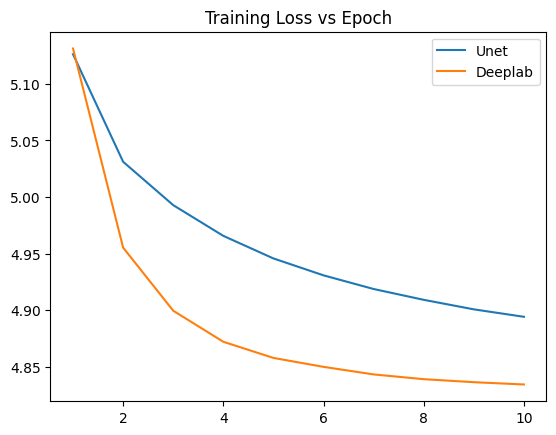

In [11]:
import matplotlib.pyplot as plt
import numpy as np
epoches = np.arange(1, 11)
plt.figure()
plt.plot(epoches, epoch_train_losses_1)
plt.plot(epoches, epoch_train_losses_2)
plt.legend(['Unet', 'Deeplab'])
plt.title('Training Loss vs Epoch')
plt.show()